In [449]:

import uuid
from pathlib import Path
from experiments.anomaly_detection import AnomalyDetection
import matplotlib.pyplot as plt
import numpy
import seaborn as sns
import torch
import yaml
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.seed import seed_everything
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

from dataloaders.tabular import TabularDataset
from experiments.dnn_ae_experiment import DNNAEExperiment
from models.dnn_ae import Autoencoder
from niapy_extension.wrapper import *
from sklearn.metrics import roc_curve, auc

### Setup configuration

In [450]:
RUN_UUID = uuid.uuid4().hex

with open("configs/dnn_ae.yaml", 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

config['logging_params']['save_dir'] += RUN_UUID + '/'
Path(config['logging_params']['save_dir']).mkdir(parents=True, exist_ok=True)
seed_everything(config['exp_params']['manual_seed'], True)
datamodule = TabularDataset(**config["data_params"], pin_memory=True)
datamodule.setup()

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\pytorch_lightning\utilities\seed.py:48: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning_lite.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
Global seed set to 1265


### 2D Scatter plot (anomalies vs. normal)

In [451]:
datamodule = TabularDataset(**config["data_params"], pin_memory=True)
datamodule.setup()
x = datamodule.test_dataset.x_test.cpu().detach().numpy()
y = datamodule.test_dataset.y_test.cpu().detach().numpy()
x.shape

(530, 60)

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


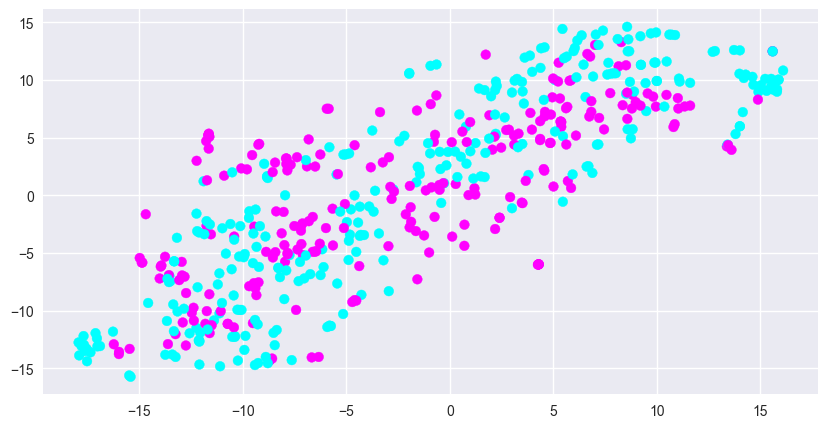

In [452]:
# https://towardsdatascience.com/dimension-reduction-techniques-with-python-f36ca7009e5c
X_tsne = TSNE(n_components=2, learning_rate=1000, n_iter=1000, perplexity=60).fit_transform(x)
X_pca = PCA().fit_transform(x)
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y[:x.shape[0]], cmap='cool')
plt.savefig('scatter2D.png', dpi=300)

### Construct model and experiment

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


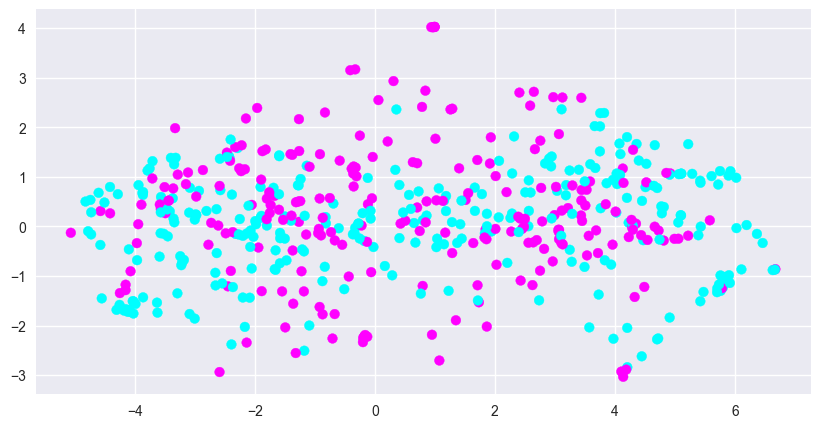

In [453]:
# https://towardsdatascience.com/dimension-reduction-techniques-with-python-f36ca7009e5c
X_tsne = TSNE(n_components=2, learning_rate=1000, n_iter=1000, perplexity=200).fit_transform(x)
X_pca = PCA().fit_transform(x)
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y[:x.shape[0]], cmap='cool')
plt.savefig('scatter2D.png', dpi=300)

### 3D Scatter plot (anomalies vs. normal)

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


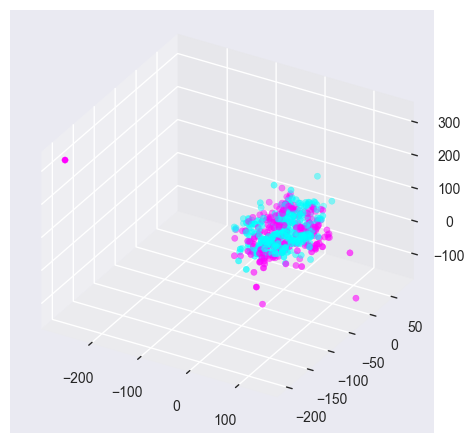

In [454]:
X_tsne = TSNE(n_components=3, learning_rate=250, n_iter=1000, perplexity=10).fit_transform(x)
X_pca = PCA().fit_transform(x)
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
# Data for three-dimensional scattered points
zdata = X_tsne[:, 0]
xdata = X_tsne[:, 1]
ydata = X_tsne[:, 2]
ax.set_proj_type('ortho')
ax.scatter3D(xdata, ydata, zdata, c=y[:x.shape[0]], cmap='cool')
plt.savefig('scatter3D.png', dpi=300)

In [455]:
solution = [0.8070343381441256, 0.9011601984035102, 1.0, 0.4218074123464228, 0.0, 0.31186481740549254,
            0.1293049941554778]
solution = numpy.array(solution)
model = Autoencoder(solution, **config)
saving_path = config['logging_params']['save_dir'] + "manual_alg_" + model.hash_id
Path(saving_path).mkdir(parents=True, exist_ok=True)

+------------------------------------------+---------------+-----------------+-------------+-----------------------+-------------+--------------------+----------------+-----------------+----------------------------------------------------------+----------------------------------------------------------+
|                    ID                    |  Shape (y1)   | Layer step (y2) | Layers (y3) | Activation func. (y4) | Epochs (y5) | Learning rate (y6) | Optimizer (y7) | Bottleneck size |                         Encoder                          |                         Decoder                          |
+------------------------------------------+---------------+-----------------+-------------+-----------------------+-------------+--------------------+----------------+-----------------+----------------------------------------------------------+----------------------------------------------------------+
| 9140c9e2a3e43a01fd77df494cf1d57a81eadfe8 | A-SYMMETRICAL |       54        |      1

In [456]:
model.num_epochs = 3
early_stop_callback = EarlyStopping(monitor=config['early_stop']['monitor'],
                                    min_delta=config['early_stop']['min_delta'],
                                    patience=config['early_stop']['patience'],
                                    verbose=False,
                                    check_finite=True,
                                    mode="max")

experiment = DNNAEExperiment(model, config['exp_params'], config['model_params']['n_features'])
config['trainer_params']['max_epochs'] = model.num_epochs
tb_logger = TensorBoardLogger(save_dir=config['logging_params']['save_dir'],
                              name="manual_alg_" + model.hash_id)

runner = Trainer(logger=tb_logger,
                 enable_progress_bar=False,
                 # accelerator="gpu",
                 # devices=1,
                 # auto_select_gpus=True,
                 callbacks=[
                     LearningRateMonitor(),
                     ModelCheckpoint(save_top_k=1,
                                     dirpath=os.path.join(tb_logger.log_dir, "checkpoints"),
                                     monitor="val_loss",
                                     save_last=True),
                     early_stop_callback,
                 ],
                 # strategy=DDPPlugin(find_unused_parameters=False),
                 **config['trainer_params'])

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (RMSE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usi

Train and save mode to file

In [457]:
print(f"======= Training {config['model_params']['name']} =======")
print(f'\nTraining start: {datetime.now().strftime("%H:%M:%S-%d/%m/%Y")}')
runner.fit(experiment, datamodule=datamodule)
print(f'\nTraining end: {datetime.now().strftime("%H:%M:%S-%d/%m/%Y")}')
torch.save(model.state_dict(), saving_path + "/manual_model.pt")

Load model from file

In [458]:
model = Autoencoder(solution, **config)
# model.load_state_dict(torch.load(saving_path + "/manual_model.pt"))
model.load_state_dict(torch.load(
    "logs/0540b6ceca254cb5ac8763749a1037b2/1138_DifferentialEvolution_9140c9e2a3e43a01fd77df494cf1d57a81eadfe8/model.pt"))
model.eval()

+------------------------------------------+---------------+-----------------+-------------+-----------------------+-------------+--------------------+----------------+-----------------+----------------------------------------------------------+----------------------------------------------------------+
|                    ID                    |  Shape (y1)   | Layer step (y2) | Layers (y3) | Activation func. (y4) | Epochs (y5) | Learning rate (y6) | Optimizer (y7) | Bottleneck size |                         Encoder                          |                         Decoder                          |
+------------------------------------------+---------------+-----------------+-------------+-----------------------+-------------+--------------------+----------------+-----------------+----------------------------------------------------------+----------------------------------------------------------+
| 9140c9e2a3e43a01fd77df494cf1d57a81eadfe8 | A-SYMMETRICAL |       54        |      1

Autoencoder(
  (encoding_layers): ModuleList(
    (0): Linear(in_features=60, out_features=6, bias=True)
  )
  (decoding_layers): ModuleList(
    (0): Linear(in_features=6, out_features=60, bias=True)
  )
)

### Predict with loaded model

In [459]:
# predict with the model
dataloader_iterator = iter(datamodule.test_dataloader())
rmse_list = list()
counter = 0
for data, target in dataloader_iterator:
    data = data.to('cpu')
    reconstructed, input = model.forward(data)
    rmse = mean_squared_error(input.detach().numpy(), reconstructed.detach().numpy(), squared=True)
    rmse_list.append(rmse)
    counter += 1

print(counter)
print(f"Number of elements: {len(rmse_list)}")
print(sum(rmse_list) / len(rmse_list))

53
Number of elements: 53
10.512702662989778


### Calculate AUC value based on anomaly detection

In [460]:


anomaly_detection = AnomalyDetection([0], [1])
dataloader_iterator = iter(datamodule.test_dataloader())

inputs = []
outputs = []
scores = []
targets = []

"Loop over dataset"
for data, target in dataloader_iterator:
    data = data.to('cpu')
    reconstructed, input = model.forward(data)

    "Loop over batch"
    for x, y, z in zip(input, reconstructed, target):
        inputs.append(x)
        outputs.append(y)
        targets.append(z.item())
        score = torch.sqrt(torch.sum((y - x) ** 2, dim=tuple(range(1, y.dim()))))
        scores.append(score.detach().numpy().tolist())

anomaly_detection.find(inputs, outputs, targets)
print(f"Model AUC score: {anomaly_detection.AUC}")

Model AUC score: 0.705


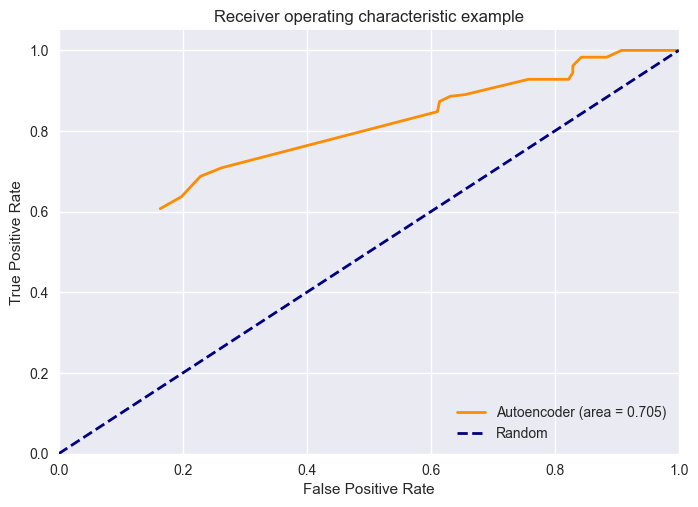

In [461]:
plt.figure()
lw = 2
plt.plot(
    anomaly_detection.FPR_array,
    anomaly_detection.TPR_array,
    color="darkorange",
    lw=lw,
    label="Autoencoder (area = %0.3f)" % anomaly_detection.AUC,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--", label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [462]:
# https://stackoverflow.com/questions/58894137/roc-auc-score-for-autoencoder-and-isolationforest
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], thresholds[i] = roc_curve(targets, scores)
    roc_auc[i] = auc(fpr[i], tpr[i])

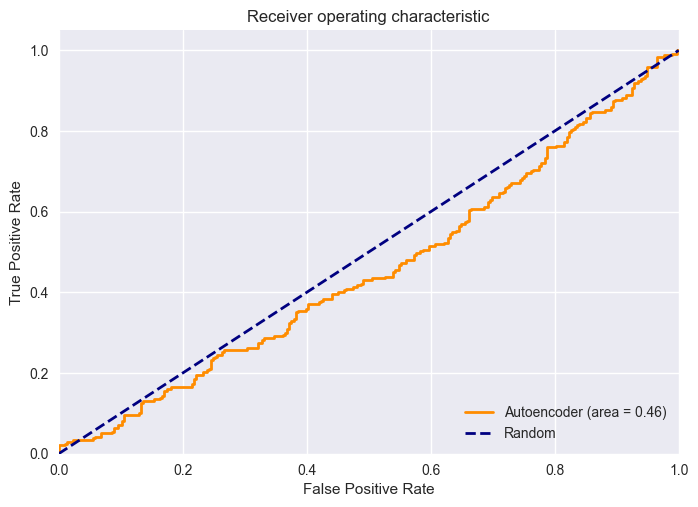

In [463]:
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="Autoencoder (area = %0.2f)" % roc_auc[1],
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--", label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

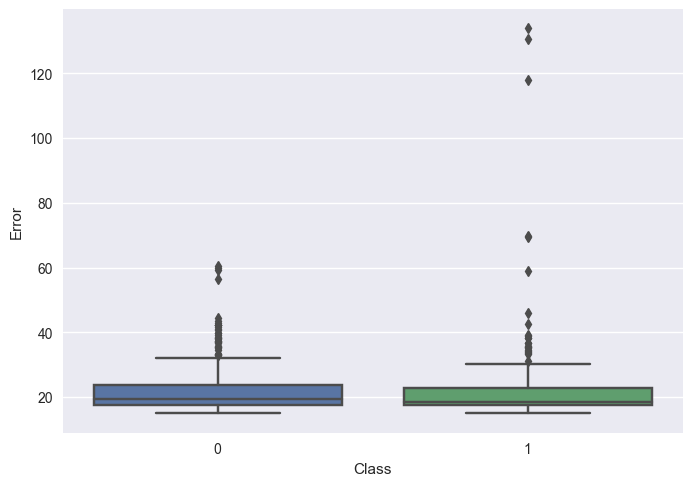

In [464]:
df = pd.DataFrame(list(zip(scores, targets)), columns=['Error', 'Class'])
df = df.round(1)
sns.boxplot(y=df["Error"], x=df["Class"])
plt.show()

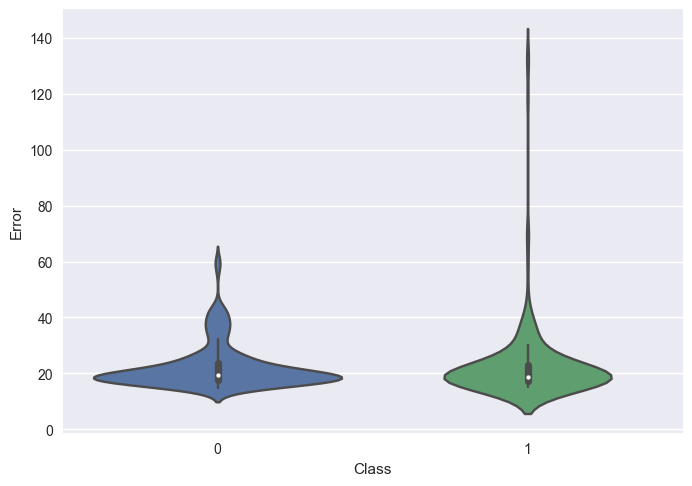

In [465]:
sns.violinplot(y=df["Error"], x=df["Class"], kind="kde")
plt.show()

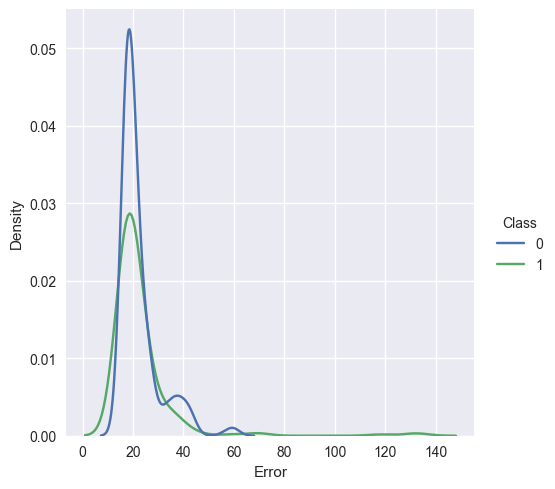

In [466]:
sns.displot(df, x="Error", hue="Class", kind="kde")
plt.show()

In [467]:
df[df.Class == 0].describe()

,Error,Class
count,293.000000,293.0
mean,22.343345,0.0
std,7.889207,0.0
min,14.900000,0.0
25%,17.600000,0.0
50%,19.300000,0.0
75%,23.700000,0.0
max,60.400000,0.0


In [468]:
df[df.Class == 1].describe()

,Error,Class
count,237.000000,237.0
mean,22.761603,1.0
std,14.112388,0.0
min,15.100000,1.0
25%,17.400000,1.0
50%,18.600000,1.0
75%,22.900000,1.0
max,133.900000,1.0


In [469]:
df_grouped = df.groupby(['Error','Class'])['Error'].count()
df_grouped = df_grouped.reset_index(name = 'Count')

<AxesSubplot: xlabel='Count', ylabel='Error'>

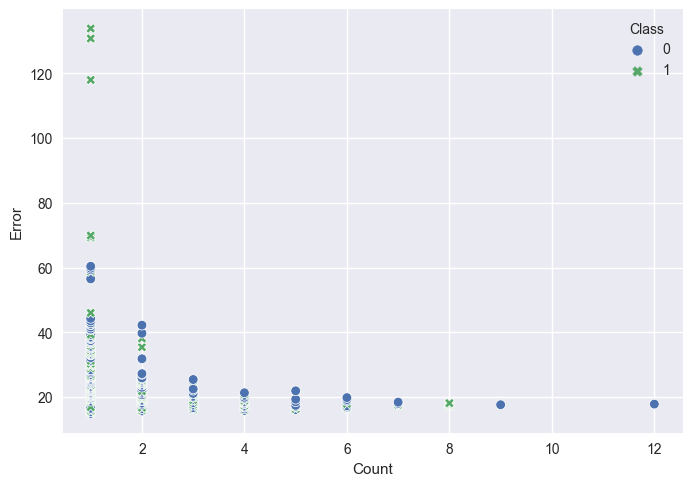

In [470]:
sns.scatterplot(data=df_grouped, x="Count", y="Error", hue="Class", style="Class")